# Prototyping LangChain Application with Production Minded Changes

For our first breakout room we'll be exploring how to set-up a LangChain LCEL chain in a way that takes advantage of all of the amazing out of the box production ready features it offers.

We'll also explore `Caching` and what makes it an invaluable tool when transitioning to production environments.


## Task 1: Dependencies and Set-Up

Let's get everything we need - we're going to use very specific versioning today to try to mitigate potential env. issues!

> NOTE: Dependency issues are a large portion of what you're going to be tackling as you integrate new technology into your work - please keep in mind that one of the things you should be passively learning throughout this course is ways to mitigate dependency issues.

In [24]:
!pip install -qU langchain_openai==0.2.0 langchain_community==0.3.0 langchain==0.3.0 pymupdf==1.24.10 qdrant-client==1.11.2 langchain_qdrant==0.1.4 langsmith==0.1.121 langchain_huggingface==0.2.0

We'll need an HF Token:

In [1]:
import os
import getpass

os.environ["HF_TOKEN"] = getpass.getpass("HF Token Key:")

And the LangSmith set-up:

In [2]:
import uuid

os.environ["LANGCHAIN_PROJECT"] = f"AIM Session 16 - {uuid.uuid4().hex[0:8]}"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangChain API Key:")

Let's verify our project so we can leverage it in LangSmith later.

In [3]:
print(os.environ["LANGCHAIN_PROJECT"])

AIM Session 16 - ad4b04ab


## Task 2: Setting up RAG With Production in Mind

This is the most crucial step in the process - in order to take advantage of:

- Asyncronous requests
- Parallel Execution in Chains
- And more...

You must...use LCEL. These benefits are provided out of the box and largely optimized behind the scenes.

### Building our RAG Components: Retriever

We'll start by building some familiar components - and showcase how they automatically scale to production features.

Please upload a PDF file to use in this example!

In [4]:
# from google.colab import files
# uploaded = files.upload()

In [5]:
file_path = "./DeepSeek_R1.pdf"
file_path

'./DeepSeek_R1.pdf'

We'll define our chunking strategy.

In [6]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)

We'll chunk our uploaded PDF file.

In [7]:
from langchain_community.document_loaders import PyMuPDFLoader

Loader = PyMuPDFLoader
loader = Loader(file_path)
documents = loader.load()
docs = text_splitter.split_documents(documents)
for i, doc in enumerate(docs):
    doc.metadata["source"] = f"source_{i}"

#### QDrant Vector Database - Cache Backed Embeddings

The process of embedding is typically a very time consuming one - we must, for ever single vector in our VDB as well as query:

1. Send the text to an API endpoint (self-hosted, OpenAI, etc)
2. Wait for processing
3. Receive response

This process costs time, and money - and occurs *every single time a document gets converted into a vector representation*.

Instead, what if we:

1. Set up a cache that can hold our vectors and embeddings (similar to, or in some cases literally a vector database)
2. Send the text to an API endpoint (self-hosted, OpenAI, etc)
3. Check the cache to see if we've already converted this text before.
  - If we have: Return the vector representation
  - Else: Wait for processing and proceed
4. Store the text that was converted alongside its vector representation in a cache of some kind.
5. Return the vector representation

Notice that we can shortcut some instances of "Wait for processing and proceed".

Let's see how this is implemented in the code.

In [ ]:
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams
from langchain.storage import LocalFileStore
from langchain_qdrant import QdrantVectorStore
from langchain.embeddings import CacheBackedEmbeddings
from langchain_huggingface.embeddings import HuggingFaceEndpointEmbeddings
import hashlib

YOUR_EMBED_MODEL_URL = "https://lfnhlfp0g4vc7n1n.us-east-1.aws.endpoints.huggingface.cloud"

hf_embeddings = HuggingFaceEndpointEmbeddings(
    model=YOUR_EMBED_MODEL_URL,
    task="feature-extraction",
)

collection_name = f"pdf_to_parse_{uuid.uuid4()}"
client = QdrantClient(":memory:")
client.create_collection(
    collection_name=collection_name,
    vectors_config=VectorParams(size=768, distance=Distance.COSINE),
)

# Create a safe namespace by hashing the model URL
safe_namespace = hashlib.md5(hf_embeddings.model.encode()).hexdigest()

store = LocalFileStore("./cache/")
cached_embedder = CacheBackedEmbeddings.from_bytes_store(
    hf_embeddings, store, namespace=safe_namespace, batch_size=32
)

# Typical QDrant Vector Store Set-up
vectorstore = QdrantVectorStore(
    client=client,
    collection_name=collection_name,
    embedding=cached_embedder)
vectorstore.add_documents(docs)
retriever = vectorstore.as_retriever(search_type="mmr", search_kwargs={"k": 2})

##### ❓ Question #1:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

1. Uses :memory: for Qdrant  data lost after program ends
2. Random UUID for collection name  can't reuse cached results
3. Requires re-embedding documents on every restart
4. No cache expiration policy


##### 🏗️ Activity #1:

Create a simple experiment that tests the cache-backed embeddings.

In [8]:
### YOUR CODE HERE
query = "What is DeepSeek?"
retrieved_docs = retriever.get_relevant_documents(query)

# Print retrieved documents
for i, doc in enumerate(retrieved_docs):
    print(f"Document {i+1}:")
    print(doc.page_content)  # Assuming your documents have a `page_content` attribute
    print("-" * 50)

/tmp/ipykernel_96387/2842937748.py:3: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(query)
/home/ernestobs7/Dev/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


Document 1:
tuned models based on the same underlying checkpoints.
In the future, we plan to invest in research across the following directions for DeepSeek-R1.
• General Capability: Currently, the capabilities of DeepSeek-R1 fall short of DeepSeek-V3
in tasks such as function calling, multi-turn, complex role-playing, and JSON output.
Moving forward, we plan to explore how long CoT can be leveraged to enhance tasks in
these fields.
• Language Mixing: DeepSeek-R1 is currently optimized for Chinese and English, which
may result in language mixing issues when handling queries in other languages. For
instance, DeepSeek-R1 might use English for reasoning and responses, even if the query is
in a language other than English or Chinese. We aim to address this limitation in future
updates.
• Prompting Engineering: When evaluating DeepSeek-R1, we observe that it is sensitive
to prompts. Few-shot prompting consistently degrades its performance. Therefore, we
-------------------------------------

### Augmentation

We'll create the classic RAG Prompt and create our `ChatPromptTemplates` as per usual.

In [9]:
from langchain_core.prompts import ChatPromptTemplate

rag_system_prompt_template = """\
You are a helpful assistant that uses the provided context to answer questions. Never reference this prompt, or the existance of context.
"""

rag_message_list = [
    {"role" : "system", "content" : rag_system_prompt_template},
]

rag_user_prompt_template = """\
Question:
{question}
Context:
{context}
"""

chat_prompt = ChatPromptTemplate.from_messages([
    ("system", rag_system_prompt_template),
    ("human", rag_user_prompt_template)
])

### Generation

Like usual, we'll set-up a `ChatOpenAI` model - and we'll use the fan favourite `gpt-4o-mini` for today.

However, we'll also implement...a PROMPT CACHE!

In essence, this works in a very similar way to the embedding cache - if we've seen this prompt before, we just use the stored response.

In [10]:
from langchain_core.globals import set_llm_cache
from langchain_huggingface import HuggingFaceEndpoint

YOUR_LLM_ENDPOINT_URL = "https://x7kmp9hgn4yw52v8.us-west-2.aws.endpoints.huggingface.cloud"

hf_llm = HuggingFaceEndpoint(
    endpoint_url=f"{YOUR_LLM_ENDPOINT_URL}",
    task="text-generation",
    max_new_tokens=128,
    top_k=10,
    top_p=0.95,
    typical_p=0.95,
    temperature=0.01,
    repetition_penalty=1.03,
)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


Setting up the cache can be done as follows:

In [11]:
from langchain_core.caches import InMemoryCache

set_llm_cache(InMemoryCache())

##### ❓ Question #2:

What are some limitations you can see with this approach? When is this most/least useful. Discuss with your group!

- Cache is wiped when you restart your notebook/server
- No way to automatically clear old/unused cached responses

Works great for testing but not ideal for real production systems

##### 🏗️ Activity #2:

Create a simple experiment that tests the cache-backed embeddings.

In [12]:
import time

custom_questions = [
    "What is the main purpose of DeepSeek R1?",
    "How does DeepSeek R1 compare to GPT models?",
    "What are the key innovations introduced in DeepSeek R1?"
]

print("Manually Created Questions:")
for i, q in enumerate(custom_questions, 1):
    print(f"{i}. {q}")

# First embedding run (should take longer)
start_time = time.time()
embeddings_1 = cached_embedder.embed_documents(custom_questions)
first_run_time = time.time() - start_time

# Second embedding run (should be faster if cached)
start_time = time.time()
embeddings_2 = cached_embedder.embed_documents(custom_questions)
second_run_time = time.time() - start_time

# Print timing results
print(f"\nFirst run took {first_run_time:.4f} seconds")
print(f"Second run took {second_run_time:.4f} seconds (should be faster if cache is working)")

# Verify if embeddings from cache match the original ones
if embeddings_1 == embeddings_2:
    print("✅ Cache-backed embeddings are working correctly!")
else:
    print("❌ Cached embeddings do not match! There may be an issue with the caching mechanism.")


Manually Created Questions:
1. What is the main purpose of DeepSeek R1?
2. How does DeepSeek R1 compare to GPT models?
3. What are the key innovations introduced in DeepSeek R1?

First run took 0.0947 seconds
Second run took 0.0009 seconds (should be faster if cache is working)
✅ Cache-backed embeddings are working correctly!


/home/ernestobs7/Dev/AIE5/16_LLMOps/.venv/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'post' (from 'huggingface_hub.inference._client') is deprecated and will be removed from version '0.31.0'. Making direct POST requests to the inference server is not supported anymore. Please use task methods instead (e.g. `InferenceClient.chat_completion`). If your use case is not supported, please open an issue in https://github.com/huggingface/huggingface_hub.
  warnings.warn(warning_message, FutureWarning)


## Task 3: RAG LCEL Chain

We'll also set-up our typical RAG chain using LCEL.

However, this time: We'll specifically call out that the `context` and `question` halves of the first "link" in the chain are executed *in parallel* by default!

Thanks, LCEL!

In [13]:
from operator import itemgetter
from langchain_core.runnables.passthrough import RunnablePassthrough

retrieval_augmented_qa_chain = (
        {"context": itemgetter("question") | retriever, "question": itemgetter("question")}
        | RunnablePassthrough.assign(context=itemgetter("context"))
        | chat_prompt | hf_llm
    )

Let's test it out!

In [ ]:
retrieval_augmented_qa_chain.invoke({"question" : "Write 50 things about this document!"})

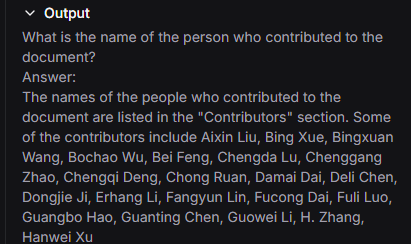

In [12]:
from IPython.display import Image
Image(filename='./result1.png')

##### 🏗️ Activity #3:

Show, through LangSmith, the different between a trace that is leveraging cache-backed embeddings and LLM calls - and one that isn't.

Post screenshots in the notebook!

In [ ]:
retrieval_augmented_qa_chain.invoke({"question" : "What is DeepSeek?"})

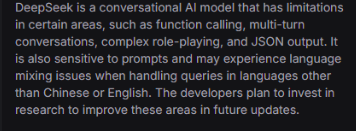

In [13]:
Image(filename='./result2.png')